# Spaceship Titanic dataset (Kaggle)

The models implemented here use the following predictors:

- `Age`: The age of the passenger. [`numeric`]
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. [`numeric`]
- `HomePlanet`: The planet the passenger departed from, typically their planet of permanent residence. [`categorical`]
- `CryoSleep`: Indicates whether the passenger was put into suspended animation. Passengers in cryosleep are confined to their cabins. [`categorical`]
- `Destination`: The planet the passenger will be debarking to. [`categorical`]
- `VIP`: Whether the passenger has paid for special VIP service during the voyage. [`categorical`]
- `group_size_bin`: The size of the group the passenger is travellin with (category: "g1", "g2", "g3", "g4more", for 1, 2, 3 or 4-or-more, respectively). [`categorical`]
- `deck`: The deck information from **Cabin** column. [`categorical`]
- `side`: The side information from **Cabin** column. [`categorical`]

\
Label:
- `Transported`: Whether the passenger was transported to another dimension. [`binary`]

# Load libraries

In [194]:
from pathlib import Path
import sys
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV

np.random.seed(123)

# Python version
print(f"sys: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

sys: 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
numpy: 1.24.2
scipy: 1.10.1
pandas: 1.5.3
matplotlib: 3.7.1


# Load data

In [113]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)
print(f"Shape: {X_y_train.shape}")

Shape: (6954, 14)


In [114]:
print(X_y_train.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [115]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6789 non-null   object 
 2   CryoSleep     6782 non-null   object 
 3   Cabin         6795 non-null   object 
 4   Destination   6805 non-null   object 
 5   Age           6809 non-null   float64
 6   VIP           6800 non-null   object 
 7   RoomService   6801 non-null   float64
 8   FoodCourt     6796 non-null   float64
 9   ShoppingMall  6788 non-null   float64
 10  Spa           6808 non-null   float64
 11  VRDeck        6809 non-null   float64
 12  Name          6786 non-null   object 
 13  Transported   6954 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 713.2+ KB


In [116]:
X_y_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,7527_01,Earth,False,F/1561/P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley,True
1,7083_01,Europa,True,C/259/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Betenar Pirejus,True
2,2755_01,Europa,True,B/85/P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Beneba Glousspidy,True
3,4127_01,Europa,NaN,B/130/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Dsch Ainserfle,True
4,7972_02,Europa,False,B/260/P,TRAPPIST-1e,35.0,False,NaN,246.0,25.0,42.0,3730.0,Atinon Cattyried,False


In [117]:
print(f"shape X_y_train: {X_y_train.shape}")

shape X_y_train: (6954, 14)


In [118]:
# NOTE: "drop()" create a copy of the data original dataset
X_train = X_y_train.drop(["Transported"], axis=1)
y_train = X_y_train.loc[:, "Transported"].copy()

print(f"shape X_train: {X_train.shape}")
print(f"shape y_train: {y_train.shape}")

shape X_train: (6954, 13)
shape y_train: (6954,)


# Define functions

In [119]:
def print_best_model(gs, print_all_scores=False):
    # gs: grid search object
    
    # print(f"Best estimator:\n{gs.best_estimator_}")
    print(f"Best parameters:\n{gs.best_params_}")
    print(f"\nBest score: {gs.best_score_:.3f}")
    print(f"Mean accuracy on the full train set: {gs.score(X_train, y_train):.3f}")

    scores = gs.cv_results_["mean_test_score"].round(3)
    plt.figure(figsize=(10,3))
    plt.plot(scores, "bo-")
    max_score = np.max(scores)
    max_idx = np.argmax(scores)
    plt.plot(max_idx, max_score, "ro")
    plt.xlabel("Candidates")
    plt.ylabel("Accuracy")
    plt.title("Mean accuracy")
    plt.show()

    if print_all_scores:
        # for params, score in zip(gs.cv_results_["params"], gs.cv_results_["mean_test_score"]):
        #     results = ""
        #     for param, value in zip(params.keys(), params.values()):
        #         results += f"{param}: {value}"
        #     results += f" ---- score: {score:.3f}"
        #     print(results)
        results = pd.DataFrame(gs.cv_results_["params"])
        results["mean_score"] = gs.cv_results_["mean_test_score"].round(3)
        results["sd_score"] = gs.cv_results_["std_test_score"].round(3)
        results["rank_score"] = gs.cv_results_["rank_test_score"]
        # print(results)
        return results


def add_metrics(dictionary, y, y_pred, mod_name):
    # dictionary: a dictionary to which the metrics are added

    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    dictionary[mod_name] = {
        "accuracy": np.round(acc, 3),
        "confusion_matrix": cm,
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "f1_score": np.round(f1, 3)
    }

    return dictionary


def print_metrics(m):
    print(f"Accuracy is {m['accuracy']:.2f}.")
    print(f"When the model claims a passenger was transported to another dimension, it is correct {m['precision']*100} % of the time (precision).")
    print(f"The model detects {m['recall']*100:.2f} % of the passengers that were transported to another dimension (recall).")
    print(f"The F1 score is {m['f1_score']*100:.2f}.")


def display_cm(cm):
    # cm: a confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


def compare_models(models):
    mods_table = pd.DataFrame.from_dict(models)
    return mods_table.loc[["accuracy", "precision", "recall", "f1_score"],:]

# Define pipelines

In [120]:
# Define columns to convert
c_cat = ["HomePlanet", "Cabin", "Destination"]
c_str = ["PassengerId", "Name"]

In [121]:
# Function to convert data type & add column
def convert_df(df_in: pd.DataFrame,
               col_cat: list[str],
               col_str: list[str],
               # col_bool: list[str]
 ) -> pd.DataFrame:
    """Converts the specified columns to categorical, string or bool types."""

    df_out = df_in.copy()

    for column in col_cat:
        df_out[column] = df_out[column].astype("category")
    
    for column in col_str:
        df_out[column] = df_out[column].astype("string")

    return df_out

## CombinedAttributesAdder

Define a class that transforms and select various features.

In [122]:
# TransformerMixin: add method ".fit_transform()"
# BaseEstimator: add methods ".get_params()" and ".set_params()"
# We need 3 methods:
# 1) .fit()
# 2) .transform()
# 3) .fit_transform() (provided by "TransformerMixin")
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # avoid '*args' or "**kargs" in "__init__"
    def __init__(self):
        pass

    # fit is needed later for the pipilene
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert column type
        X = convert_df(
            df_in=X,
            col_cat=c_cat,
            col_str=c_str,
            #col_bool=c_bool,
        )

        # Add "group" and "group_n"
        X[["group", "group_n"]] = X.PassengerId.str.split("_", expand=True)

        # Add "group_size" (a column with the size of the group)
        count_group_size = (
             X
             .value_counts(["group"], sort=False)
             .rename("group_size")
             .reset_index()
        )
        X = pd.merge(X, count_group_size, how="left", on="group")

        # Add "group_size_bin"
        X.loc[:, "group_size_bin"] = np.nan
        X.loc[X.group_size == 1, "group_size_bin"] = "g1"
        X.loc[X.group_size == 2, "group_size_bin"] = "g2"
        X.loc[X.group_size == 3, "group_size_bin"] = "g3"
        X.loc[X.group_size >= 4, "group_size_bin"] = "g4more"
        X["group_size_bin"] = X["group_size_bin"].astype("category")

        # Add "deck", "num" and "side"
        X[["deck", "num", "side"]] = X.Cabin.str.split("/", expand=True)
        X["deck"] = X["deck"].astype("category")
        X["num"] = X["num"].astype("string")
        X["side"] = X["side"].astype("category")
        
        # Drop unused columns
        cols_to_drop = ['PassengerId', 'Cabin', 'Name', 'group',
                        'group_n', 'group_size', 'num']
        X.drop(columns=cols_to_drop, inplace=True)

        return X

## num_pipeline

It preprocesses the numerical attributes with `SimpleImputer()` and `StandardScaler()`.

In [123]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
num_pipeline = Pipeline([
    # replace NA with mean
    ('imputer', SimpleImputer(strategy='mean')),
    # standardize the variables: z = (x - mean) / SD
    ('std_scaler', StandardScaler())])

## cat_pipeline

It preprocesses the categorical attributed with `SimpleImputer()` and `OneHotEncoder()`.

In [124]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
cat_pipeline = Pipeline([
    # replace NA with mode
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # apply "OneHotEncoder()"
    ('one_hot', OneHotEncoder(drop='if_binary'))])

## Combine pipelines

In [125]:
list_num_attribs = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
list_cat_attribs = ["HomePlanet", "CryoSleep", "Destination", "VIP", "group_size_bin", "deck", "side"]

In [126]:
# ColumnTransformer requires tuples with:
# - a name
# - a transformer
# - a list of names (or indices) of columns to which the transformer is applied

cols_transformer = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, list_num_attribs),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, list_cat_attribs)])

In [127]:
full_pipeline = Pipeline([
    # transform/add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform numerical and categorical attributes
    ("cols_transformer", cols_transformer)])

In [128]:
# print(full_pipeline.get_params().keys())
# print(full_pipeline.get_params().items())
print(full_pipeline.get_params())


{'memory': None, 'steps': [('attribs_adder', CombinedAttributesAdder()), ('cols_transformer', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'group_size_bin', 'deck', 'side'])]))], 'verbose': False,

In [129]:
for i in full_pipeline.get_params().keys():
    print(i)

memory
steps
verbose
attribs_adder
cols_transformer
cols_transformer__n_jobs
cols_transformer__remainder
cols_transformer__sparse_threshold
cols_transformer__transformer_weights
cols_transformer__transformers
cols_transformer__verbose
cols_transformer__verbose_feature_names_out
cols_transformer__num
cols_transformer__cat
cols_transformer__num__memory
cols_transformer__num__steps
cols_transformer__num__verbose
cols_transformer__num__imputer
cols_transformer__num__std_scaler
cols_transformer__num__imputer__add_indicator
cols_transformer__num__imputer__copy
cols_transformer__num__imputer__fill_value
cols_transformer__num__imputer__keep_empty_features
cols_transformer__num__imputer__missing_values
cols_transformer__num__imputer__strategy
cols_transformer__num__imputer__verbose
cols_transformer__num__std_scaler__copy
cols_transformer__num__std_scaler__with_mean
cols_transformer__num__std_scaler__with_std
cols_transformer__cat__memory
cols_transformer__cat__steps
cols_transformer__cat__verbo

# Logistic regression

In [130]:
log_cls = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Logistic regression
    ("log", LogisticRegression(random_state=123))])

In [131]:
list(log_cls["log"].get_params().keys())

['C',
 'class_weight',
 'dual',
 'fit_intercept',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_jobs',
 'penalty',
 'random_state',
 'solver',
 'tol',
 'verbose',
 'warm_start']

In [132]:
param_grid = {
    # C: smaller values specify stronger regularization
    "log__C": [0.1, 1.0, 10.0, 100.0, 1000.0]}

gs_log = GridSearchCV(
    estimator=log_cls,
    param_grid=param_grid,
    cv=5, # train across 5 folds
    scoring='accuracy',
    verbose=1)

In [133]:
gs_log.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        Pipeline(steps=[('attribs_adder',
                                                         CombinedAttributesAdder()),
                                                        ('cols_transformer',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('std_scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['Age',
                                                                                           'RoomService',
                                                                                           'FoodCourt',
                                                                                           'ShoppingMall',
                                                                                           'Spa',
                                                                                           'VRDeck']),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('one_hot',
                                                                                                           OneHotEncoder(drop='if_binary'))]),
                                                                                          ['HomePlanet',
                                                                                           'CryoSleep',
                                                                                           'Destination',
                                                                                           'VIP',
                                                                                           'group_size_bin',
                                                                                           'deck',
                                                                                           'side'])]))])),
                                       ('log',
                                        LogisticRegression(random_state=123))]),
             param_grid={'log__C': [0.1, 1.0, 10.0, 100.0, 1000.0]},
             scoring='accuracy', verbose=1)

Best parameters:
{'log__C': 100.0}

Best score: 0.788
Mean accuracy on the full train set: 0.790


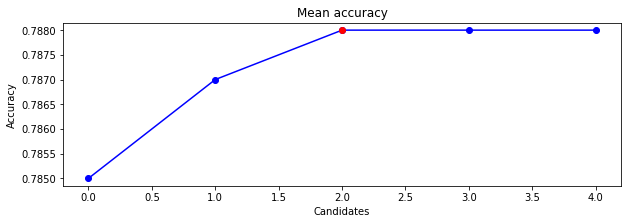

In [134]:
print_best_model(gs_log)

In [135]:
models_score = dict()
y_pred = gs_log.best_estimator_.predict(X_train)
models_score = add_metrics(models_score, y_train, y_pred, "log_regression")

In [136]:
print_metrics(models_score["log_regression"])

Accuracy is 0.79.
When the model claims a passenger was transported to another dimension, it is correct 78.10000000000001 % of the time (precision).
The model detects 80.90 % of the passengers that were transported to another dimension (recall).
The F1 score is 79.50.


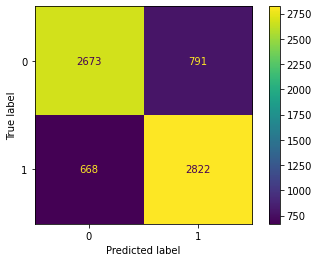

In [137]:
display_cm(models_score["log_regression"]["confusion_matrix"])

# SVM Classifier

In [138]:
svm_cls = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # SVM Classifier
    # ("probability" is set to False "random_state" has no effect on the results)
    ("svm", SVC(random_state=456))])

In [139]:
list(svm_cls["svm"].get_params().keys())

['C',
 'break_ties',
 'cache_size',
 'class_weight',
 'coef0',
 'decision_function_shape',
 'degree',
 'gamma',
 'kernel',
 'max_iter',
 'probability',
 'random_state',
 'shrinking',
 'tol',
 'verbose']

In [140]:
param_grid = {
    "svm__kernel": ["rbf", "poly"],
    # C: smaller values specify stronger regularization
    "svm__C": [0.1, 1.0, 10.0, 100.0],
    #"svm__gamma": [0.1, 5, "scale", "auto"]
    }

gs_svm = GridSearchCV(
    estimator=svm_cls,
    param_grid=param_grid,
    cv=5, # train across 5 folds
    scoring='accuracy',
    verbose=1)

In [141]:
gs_svm.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        Pipeline(steps=[('attribs_adder',
                                                         CombinedAttributesAdder()),
                                                        ('cols_transformer',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('std_scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['Age',
                                                                                           'RoomService',
                                                                                           'FoodCourt',
                                                                                           'ShoppingMall',
                                                                                           'Spa',
                                                                                           'VRDeck']),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('one_hot',
                                                                                                           OneHotEncoder(drop='if_binary'))]),
                                                                                          ['HomePlanet',
                                                                                           'CryoSleep',
                                                                                           'Destination',
                                                                                           'VIP',
                                                                                           'group_size_bin',
                                                                                           'deck',
                                                                                           'side'])]))])),
                                       ('svm', SVC(random_state=456))]),
             param_grid={'svm__C': [0.1, 1.0, 10.0, 100.0],
                         'svm__kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

Best parameters:
{'svm__C': 10.0, 'svm__kernel': 'poly'}

Best score: 0.797
Mean accuracy on the full train set: 0.828


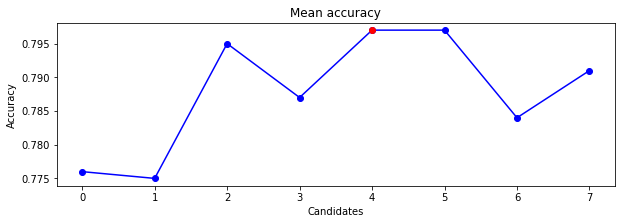

In [142]:
results = print_best_model(gs_svm, print_all_scores=True)

In [143]:
results

,svm__C,svm__kernel,mean_score,sd_score,rank_score
0,0.1,rbf,0.776,0.010,7
1,0.1,poly,0.775,0.010,8
2,1.0,rbf,0.795,0.008,3
3,1.0,poly,0.787,0.012,5
4,10.0,rbf,0.797,0.006,2
5,10.0,poly,0.797,0.009,1
6,100.0,rbf,0.784,0.005,6
7,100.0,poly,0.791,0.003,4


In [144]:
y_pred = gs_svm.best_estimator_.predict(X_train)
models_score = add_metrics(models_score, y_train, y_pred, "svm")

In [145]:
print_metrics(models_score["svm"])

Accuracy is 0.83.
When the model claims a passenger was transported to another dimension, it is correct 82.5 % of the time (precision).
The model detects 83.40 % of the passengers that were transported to another dimension (recall).
The F1 score is 83.00.


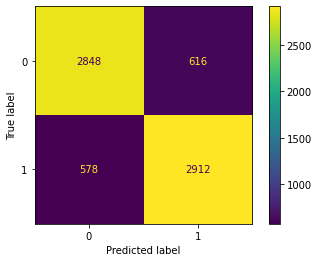

In [146]:
display_cm(models_score["svm"]["confusion_matrix"])

# Random Forest

In [184]:
rf_cls = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Random forest
    ("rf", RandomForestClassifier(random_state=852))])

In [185]:
list(rf_cls["rf"].get_params().keys())

['bootstrap',
 'ccp_alpha',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

In [186]:
param_grid = {
    "rf__n_estimators": [100, 300, 500],
    # Increasing "min_* hyperparamenters regularize the model
    # Reducing "max_* hyperparamenters regularize the model
    "rf__max_leaf_nodes": [25, 50, 75, 100]
    }

gs_rf = GridSearchCV(
    estimator=rf_cls,
    param_grid=param_grid,
    cv=5, # train across 5 folds
    scoring='accuracy',
    verbose=1,
    )

In [187]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        Pipeline(steps=[('attribs_adder',
                                                         CombinedAttributesAdder()),
                                                        ('cols_transformer',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('std_scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['Age',
                                                                                           'RoomService',
                                                                                           'FoodCourt',
                                                                                           'ShoppingMall',
                                                                                           'Spa',
                                                                                           'VRDeck']),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('one_hot',
                                                                                                           OneHotEncoder(drop='if_binary'))]),
                                                                                          ['HomePlanet',
                                                                                           'CryoSleep',
                                                                                           'Destination',
                                                                                           'VIP',
                                                                                           'group_size_bin',
                                                                                           'deck',
                                                                                           'side'])]))])),
                                       ('rf',
                                        RandomForestClassifier(random_state=852))]),
             param_grid={'rf__max_leaf_nodes': [25, 50, 75, 100],
                         'rf__n_estimators': [100, 300, 500]},
             scoring='accuracy', verbose=1)

Best parameters:
{'rf__max_leaf_nodes': 100, 'rf__n_estimators': 300}

Best score: 0.797
Mean accuracy on the full train set: 0.831


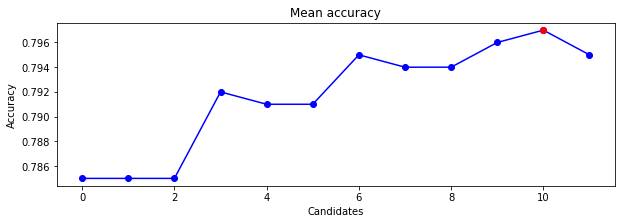

In [188]:
results = print_best_model(gs_rf, print_all_scores=True)

In [189]:
results

,rf__max_leaf_nodes,rf__n_estimators,mean_score,sd_score,rank_score
0,25,100,0.785,0.008,11
1,25,300,0.785,0.009,10
2,25,500,0.785,0.010,12
3,50,100,0.792,0.006,7
4,50,300,0.791,0.006,8
5,50,500,0.791,0.007,9
6,75,100,0.795,0.004,3
7,75,300,0.794,0.006,5
8,75,500,0.794,0.006,6
9,100,100,0.796,0.005,2


In [190]:
y_pred = gs_rf.best_estimator_.predict(X_train)
models_score = add_metrics(models_score, y_train, y_pred, "rf")

In [191]:
print_metrics(models_score["rf"])

Accuracy is 0.83.
When the model claims a passenger was transported to another dimension, it is correct 82.19999999999999 % of the time (precision).
The model detects 84.70 % of the passengers that were transported to another dimension (recall).
The F1 score is 83.50.


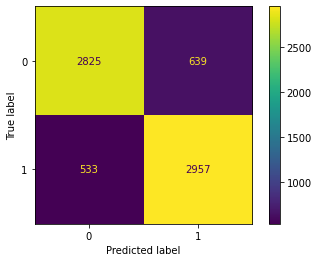

In [192]:
display_cm(models_score["rf"]["confusion_matrix"])

# Voting Classifier

In [195]:
vc_log = LogisticRegression(C=100, random_state=123)
vc_svm = SVC(kernel='poly', C=10, random_state=456)
vc_rf = RandomForestClassifier(n_estimators=300, max_leaf_nodes=100, random_state=852)

vc_estimators = VotingClassifier(
    estimators=[
        ("log_reg", vc_log),
        ("svm", vc_svm),
        ("rf", vc_rf)],
    voting="hard"
)

vot_clf = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Estimatots of the voting classifier
    ("vc", vc_estimators)])

In [196]:
vot_clf.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy=...
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side'])]))])),
                ('vc',
                 VotingClassifier(estimators=[('log_reg',
                                               LogisticRegression(C=100,
                                                                  random_state=123)),
                                              ('svm',
                                               SVC(C=10, kernel='poly',
                                                   random_state=456)),
                                              ('rf',
                                               RandomForestClassifier(max_leaf_nodes=100,
                                                                      n_estimators=300,
                                                                      random_state=852))]))])

In [197]:
y_pred = vot_clf.predict(X_train)

In [198]:
models_score = add_metrics(models_score, y_train, y_pred, "vc")

In [199]:
print_metrics(models_score["vc"])

Accuracy is 0.82.
When the model claims a passenger was transported to another dimension, it is correct 81.69999999999999 % of the time (precision).
The model detects 83.30 % of the passengers that were transported to another dimension (recall).
The F1 score is 82.50.


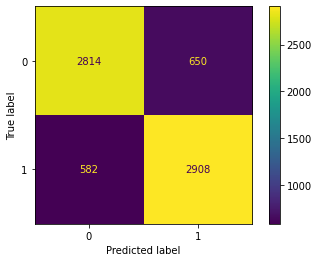

In [200]:
display_cm(models_score["vc"]["confusion_matrix"])

# Compare models

In [242]:
(
    pd.DataFrame(models_score)
    .drop(labels="confusion_matrix", axis=0)
    .astype("float")
    .round(2)
)

,log_regression,svm,rf,vc
accuracy,0.79,0.83,0.83,0.82
precision,0.78,0.82,0.82,0.82
recall,0.81,0.83,0.85,0.83
f1_score,0.80,0.83,0.84,0.82


# Test score

In [202]:
# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_test.csv"
X_y_test = load_ds(dataset_path, filename)
print(f"Shape: {X_y_test.shape}")

Shape: (1739, 14)


In [203]:
# NOTE: "drop()" create a copy of the data original dataset
X_test = X_y_test.drop(["Transported"], axis=1)
y_test = X_y_test.loc[:, "Transported"].copy()

print(f"shape X_train: {X_test.shape}")
print(f"shape y_train: {y_test.shape}")

shape X_train: (1739, 13)
shape y_train: (1739,)


In [243]:
models = [gs_log.best_estimator_, gs_svm.best_estimator_, gs_rf.best_estimator_, vot_clf]
models_names = ['log_regression', 'svm', 'random_forest', 'voting_classifier']

test_score = dict()

for model, label in zip(models, models_names):
    y_test_pred = model.predict(X_test)
    test_score = add_metrics(test_score, y_test, y_test_pred, label)
    # print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

In [245]:
(
    pd.DataFrame(test_score)
    .drop(labels="confusion_matrix", axis=0)
    .astype("float")
    .round(2)
)

,log_regression,svm,random_forest,voting_classifier
accuracy,0.80,0.81,0.81,0.81
precision,0.80,0.81,0.80,0.80
recall,0.83,0.83,0.83,0.83
f1_score,0.81,0.82,0.82,0.82


In [248]:
for mod_name in models_names:
    print_metrics(test_score[mod_name])
    print("="*80)

Accuracy is 0.80.
When the model claims a passenger was transported to another dimension, it is correct 79.5 % of the time (precision).
The model detects 82.90 % of the passengers that were transported to another dimension (recall).
The F1 score is 81.10.
Accuracy is 0.81.
When the model claims a passenger was transported to another dimension, it is correct 80.7 % of the time (precision).
The model detects 83.00 % of the passengers that were transported to another dimension (recall).
The F1 score is 81.80.
Accuracy is 0.81.
When the model claims a passenger was transported to another dimension, it is correct 80.4 % of the time (precision).
The model detects 82.70 % of the passengers that were transported to another dimension (recall).
The F1 score is 81.50.
Accuracy is 0.81.
When the model claims a passenger was transported to another dimension, it is correct 80.5 % of the time (precision).
The model detects 83.40 % of the passengers that were transported to another dimension (recall).

# Test set (to submit)

In [249]:
# Load dataset
dataset_path = Path().absolute() / "data"
filename = "test.csv"
X_test_to_submit = load_ds(dataset_path, filename)
print(f"Shape: {X_test_to_submit.shape}")

Shape: (4277, 13)


In [250]:
y_test_to_submit = vot_clf.predict(X_test_to_submit)

In [252]:
print(y_test_to_submit.shape)

(4277,)


In [255]:
df_to_csv = pd.DataFrame(data={
    "PassengerId":X_test_to_submit["PassengerId"],
    "Transported":y_test_to_submit})

In [256]:
df_to_csv.head(6)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True


In [260]:
path_to_save = Path().absolute() / "submission" / "submission_1.csv"
df_to_csv.to_csv(
    path_or_buf=path_to_save,
    index=False
)